In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os


In [3]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


11490434/11490434 [==============================] - 1s 0us/step


In [18]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


In [19]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [21]:
import time

EPOCHS = 60
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    generator_losses = []
    discriminator_losses = []
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        generator_losses.append(gen_loss)
        discriminator_losses.append(disc_loss)

        print (f'Time for epoch {epoch+1} is {time.time()-start} sec')

    return generator_losses, discriminator_losses

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_losses, discriminator_losses = train(train_dataset, EPOCHS)


Time for epoch 1 is 57.040189266204834 sec
Time for epoch 2 is 43.445393562316895 sec
Time for epoch 3 is 43.74435591697693 sec
Time for epoch 4 is 43.645939350128174 sec
Time for epoch 5 is 43.59630632400513 sec
Time for epoch 6 is 43.59605360031128 sec
Time for epoch 7 is 43.62102437019348 sec
Time for epoch 8 is 43.656681060791016 sec
Time for epoch 9 is 43.680811405181885 sec
Time for epoch 10 is 43.68891906738281 sec
Time for epoch 11 is 43.703463315963745 sec
Time for epoch 12 is 43.69803333282471 sec
Time for epoch 13 is 43.703205585479736 sec
Time for epoch 14 is 43.69241189956665 sec
Time for epoch 15 is 43.69132995605469 sec
Time for epoch 16 is 43.667670249938965 sec
Time for epoch 17 is 43.6682915687561 sec
Time for epoch 18 is 43.68287968635559 sec
Time for epoch 19 is 43.68759846687317 sec
Time for epoch 20 is 43.68545985221863 sec
Time for epoch 21 is 43.684765338897705 sec
Time for epoch 22 is 43.817991971969604 sec
Time for epoch 23 is 43.62626624107361 sec
Time for ep

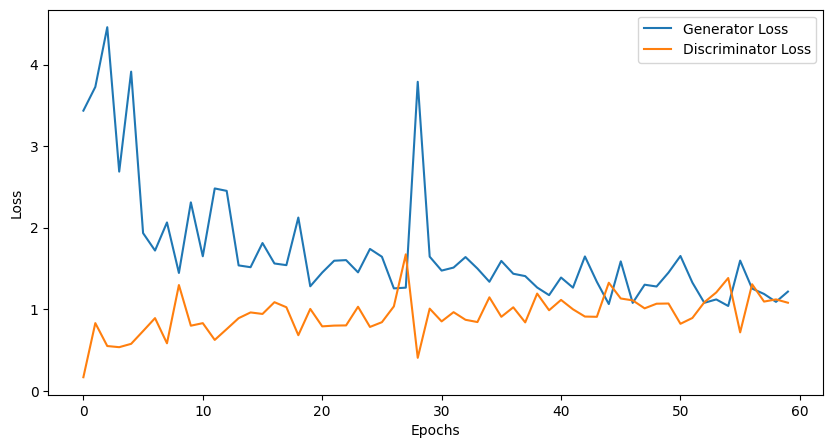

Minimum Error Observed: 0.16659587621688843


In [22]:
plt.figure(figsize=(10, 5))
plt.plot(generator_losses, label='Generator Loss')
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

min_error = min(generator_losses + discriminator_losses)
print(f"Minimum Error Observed: {min_error.numpy()}")


In [23]:
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')


In [24]:
generator.save('generator_model.keras')
discriminator.save('discriminator_model.keras')


In [25]:
generator = tf.keras.models.load_model('generator_model.keras')
discriminator = tf.keras.models.load_model('discriminator_model.keras')


In [26]:
# Plot the generated images
def plot_images(images):
    fig = plt.figure(figsize=(4, 4))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((images[i, :, :, 0] * 127.5 + 127.5).numpy().astype("uint8"), cmap='gray')
        plt.axis('off')
    plt.show()

In [27]:
num_examples_to_generate = 16
noise_dim = 100
random_noise = tf.random.normal([num_examples_to_generate, noise_dim])
generated_images = generator(random_noise, training=False)

# Pass the generated images through the discriminator
discriminator_output = discriminator(generated_images, training=False)

# Calculate the error
errors = tf.keras.losses.binary_crossentropy(tf.ones_like(discriminator_output), discriminator_output)
average_error = tf.reduce_mean(errors)
print(f"Average Discriminator Error on Generated Images: {average_error.numpy()}")

Average Discriminator Error on Generated Images: 11.069901466369629


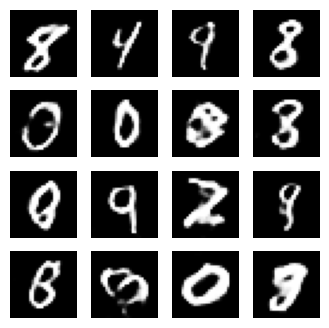

In [28]:
plot_images(generated_images)

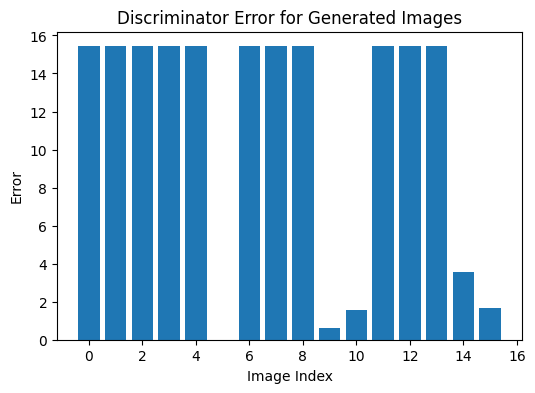

In [29]:
# Plot the error
plt.figure(figsize=(6, 4))
plt.bar(range(num_examples_to_generate), errors.numpy())
plt.xlabel('Image Index')
plt.ylabel('Error')
plt.title('Discriminator Error for Generated Images')
plt.show()